In [35]:
from collections import defaultdict

import yfinance as yf
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from finta import TA
import numpy as np
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import jaccard_score
import seaborn as sn
from tabulate import tabulate
from xgboost import XGBClassifier
from ta import add_all_ta_features
from sklearn.feature_selection import RFE
import xgboost as xgb

In [36]:
WINDOW = 16  # number of rows to look ahead to see what the price did
FETCH_INTERVAL = "60m"  # fetch data by interval (including intraday if period < 60 days)
# valid intervals: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo
# (optional, default is '1d')
INTERVAL = '2y'  # use "period" instead of start/end
# valid periods: 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max
# (optional, default is '1mo')
symbol = 'AAPL'  # Symbol of the desired stock

# one day 16 rows of data


In [37]:
data = yf.download(  # or pdr.get_data_yahoo(...
    tickers=symbol,

    period=INTERVAL,

    interval=FETCH_INTERVAL,

    # group by ticker (to access via data['SPY'])
    # (optional, default is 'column')
    group_by='ticker',

    # adjust all OHLC automatically
    # (optional, default is False)
    # auto_adjust = True,

    # download pre/post regular market hours data
    # (optional, default is False)
    prepost=True,

    # use threads for mass downloading? (True/False/Integer)
    # (optional, default is True)
    threads=False,

    # proxy URL scheme use use when downloading?
    # (optional, default is None)
    proxy=None
)
data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2019-08-21 04:00:00-04:00,52.775000,53.110000,52.775000,53.050000,53.050000,0
2019-08-21 05:00:00-04:00,53.045000,53.150000,53.045000,53.150000,53.150000,0
2019-08-21 06:00:00-04:00,53.152500,53.200000,53.045000,53.080000,53.080000,0
2019-08-21 07:00:00-04:00,53.112500,53.112500,53.000000,53.070000,53.070000,0
2019-08-21 08:00:00-04:00,53.050000,53.100000,53.000000,53.065000,53.065000,0
...,...,...,...,...,...,...
2021-08-20 15:30:00-04:00,148.087006,148.289993,147.945007,148.190002,148.190002,6188690
2021-08-20 16:00:00-04:00,148.190000,148.300000,147.616000,148.190000,148.190000,0
2021-08-20 17:00:00-04:00,148.170000,149.580000,142.382000,148.200000,148.200000,0


In [38]:
data.rename(columns={"Close": 'close', "High": 'high', "Low": 'low', 'Volume': 'volume', 'Open': 'open'}, inplace=True)
data.head(10)
important_columns = ['open', 'high', 'low', 'close', 'volume']

In [39]:

def calculate_diffs(diff_number, col_name):
    new_col_name = f'{col_name}_{diff_number}'
    data[new_col_name] = data[col_name].diff(diff_number)

In [40]:
# for name in important_columns:
#     for i in range(1, 11):
#         calculate_diffs(i, name)
#
# data.head(10)

In [41]:
data = data.dropna()

<AxesSubplot:xlabel='Datetime'>

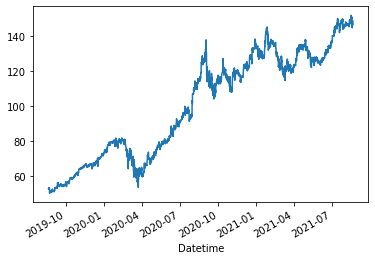

In [42]:
data['close'].plot()

In [43]:
data['close_pct'] = data['close'].pct_change()
data.head()

,open,high,low,close,Adj Close,volume,close_pct
Datetime,,,,,,,
2019-08-21 04:00:00-04:00,52.7750,53.1100,52.775,53.050,53.050,0,NaN
2019-08-21 05:00:00-04:00,53.0450,53.1500,53.045,53.150,53.150,0,0.001885
2019-08-21 06:00:00-04:00,53.1525,53.2000,53.045,53.080,53.080,0,-0.001317
2019-08-21 07:00:00-04:00,53.1125,53.1125,53.000,53.070,53.070,0,-0.000188
2019-08-21 08:00:00-04:00,53.0500,53.1000,53.000,53.065,53.065,0,-0.000094


In [44]:
data.describe()

,open,high,low,close,Adj Close,volume,close_pct
count,8379.000000,8379.000000,8379.000000,8379.000000,8379.000000,8.379000e+03,8378.000000
mean,101.062840,101.480012,100.557169,101.067265,101.067265,3.807779e+06,0.000140
std,29.988389,30.351178,29.818943,29.985327,29.985327,6.934091e+06,0.005829
min,50.250000,50.467500,50.250000,50.357500,50.357500,0.000000e+00,-0.085960
25%,71.579998,71.959999,71.220000,71.628689,71.628689,0.000000e+00,-0.001635
50%,111.450000,111.987503,110.599998,111.420000,111.420000,0.000000e+00,0.000097
75%,126.925002,127.257450,126.381002,126.922502,126.922502,5.485080e+06,0.001971
max,151.410000,438.440000,151.290000,151.670000,151.670000,9.845401e+07,0.078661


In [45]:
def _get_indicator_data(data):
    """
    Function that uses the finta API to calculate technical indicators used as the features
    :return:
    """

    data = add_all_ta_features(
        data, open="open", high="high", low="low", close="close", volume="volume", fillna=True)

    # Instead of using the actual volume value (which changes over time), we normalize it with a moving volume average
    # data['normVol'] = data['volume'] / data['volume'].ewm(5).mean()
    # for i in range(1,50):
    #     data[f'close{i}'] = data['close'].shift(i)
    # Remove columns that won't be used as features
    # del (data['Adj Close'])

    return data


In [46]:
data

,open,high,low,close,Adj Close,volume,close_pct
Datetime,,,,,,,
2019-08-21 04:00:00-04:00,52.775000,53.110000,52.775000,53.050000,53.050000,0,NaN
2019-08-21 05:00:00-04:00,53.045000,53.150000,53.045000,53.150000,53.150000,0,1.885014e-03
2019-08-21 06:00:00-04:00,53.152500,53.200000,53.045000,53.080000,53.080000,0,-1.317027e-03
2019-08-21 07:00:00-04:00,53.112500,53.112500,53.000000,53.070000,53.070000,0,-1.883949e-04
2019-08-21 08:00:00-04:00,53.050000,53.100000,53.000000,53.065000,53.065000,0,-9.421519e-05
...,...,...,...,...,...,...,...
2021-08-20 15:30:00-04:00,148.087006,148.289993,147.945007,148.190002,148.190002,6188690,7.104669e-04
2021-08-20 16:00:00-04:00,148.190000,148.300000,147.616000,148.190000,148.190000,0,-1.647484e-08
2021-08-20 17:00:00-04:00,148.170000,149.580000,142.382000,148.200000,148.200000,0,6.748094e-05


In [47]:
data.columns

Index(['open', 'high', 'low', 'close', 'Adj Close', 'volume', 'close_pct'], dtype='object')

In [48]:
def create_class_column(row, lowest_threshold, higher_threshold):
    if row['close_shift'] - row['close'] > higher_threshold:
        return 1
    if row['close_shift'] - row['close'] < lowest_threshold:
        return -1
    else:
        return 0

In [49]:
important_columns = ['open', 'high', 'low','close']


for name in important_columns:
    for i in range(1, 30):
        calculate_diffs(i, name)

data['close_shift'] = data.shift(-WINDOW)['close']
data

,open,high,low,close,Adj Close,volume,close_pct,open_1,open_2,open_3,...,close_21,close_22,close_23,close_24,close_25,close_26,close_27,close_28,close_29,close_shift
Datetime,,,,,,,,,,,,,,,,,,,,,
2019-08-21 04:00:00-04:00,52.775000,53.110000,52.775000,53.050000,53.050000,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,53.3475
2019-08-21 05:00:00-04:00,53.045000,53.150000,53.045000,53.150000,53.150000,0,1.885014e-03,0.270000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,53.2000
2019-08-21 06:00:00-04:00,53.152500,53.200000,53.045000,53.080000,53.080000,0,-1.317027e-03,0.107500,0.377500,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,52.9025
2019-08-21 07:00:00-04:00,53.112500,53.112500,53.000000,53.070000,53.070000,0,-1.883949e-04,-0.040000,0.067500,0.337500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,53.0250
2019-08-21 08:00:00-04:00,53.050000,53.100000,53.000000,53.065000,53.065000,0,-9.421519e-05,-0.062500,-0.102500,0.005000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,53.1950
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-20 15:30:00-04:00,148.087006,148.289993,147.945007,148.190002,148.190002,6188690,7.104669e-04,0.372009,0.175003,0.277512,...,0.744995,1.760101,2.139999,2.910002,2.970002,3.530002,2.880002,3.440002,3.670002,NaN
2021-08-20 16:00:00-04:00,148.190000,148.300000,147.616000,148.190000,148.190000,0,-1.647484e-08,0.102994,0.475004,0.277997,...,1.229093,0.744993,1.760099,2.139997,2.910000,2.970000,3.530000,2.880000,3.440000,NaN
2021-08-20 17:00:00-04:00,148.170000,149.580000,142.382000,148.200000,148.200000,0,6.748094e-05,-0.020000,0.082994,0.455004,...,2.110004,1.239093,0.754993,1.770099,2.149997,2.920000,2.980000,3.540000,2.890000,NaN


In [50]:
def create_class(df):
    higher_threshold = 1.5
    lowest_threshold = -1.5
    last_values_higher = []
    last_values_lower = []
    df['class_column'] = df.apply((lambda x: create_class_column(x, lowest_threshold, higher_threshold)), axis=1)
    while True:
        class_counts = df['class_column'].value_counts()
        if abs(class_counts[0] - class_counts[1]) < 15 and abs(class_counts[0] - class_counts[-1]) < 15:
            break

        if len(last_values_higher) == 3:
            last_values_higher.pop(0)
        if len(last_values_lower) == 3:
            last_values_lower.pop(0)

        last_values_higher.append(higher_threshold)
        last_values_lower.append(lowest_threshold)
        if class_counts[0] > class_counts[1]:
            higher_threshold -= 0.01
        if class_counts[0] > class_counts[-1]:
            lowest_threshold += 0.01
        if class_counts[0] < class_counts[1]:
            higher_threshold += 0.01
        if class_counts[0] < class_counts[-1]:
            lowest_threshold -= 0.01

        if higher_threshold in last_values_higher and lowest_threshold in last_values_lower:
            break
        df['class_column'] = df.apply((lambda x: create_class_column(x, lowest_threshold, higher_threshold)),
                                      axis=1)
    print(df['class_column'].value_counts())
    return df


data = create_class(data)

data


 1    2820
-1    2781
 0    2778
Name: class_column, dtype: int64


,open,high,low,close,Adj Close,volume,close_pct,open_1,open_2,open_3,...,close_22,close_23,close_24,close_25,close_26,close_27,close_28,close_29,close_shift,class_column
Datetime,,,,,,,,,,,,,,,,,,,,,
2019-08-21 04:00:00-04:00,52.775000,53.110000,52.775000,53.050000,53.050000,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,53.3475,0
2019-08-21 05:00:00-04:00,53.045000,53.150000,53.045000,53.150000,53.150000,0,1.885014e-03,0.270000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,53.2000,0
2019-08-21 06:00:00-04:00,53.152500,53.200000,53.045000,53.080000,53.080000,0,-1.317027e-03,0.107500,0.377500,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,52.9025,0
2019-08-21 07:00:00-04:00,53.112500,53.112500,53.000000,53.070000,53.070000,0,-1.883949e-04,-0.040000,0.067500,0.337500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,53.0250,0
2019-08-21 08:00:00-04:00,53.050000,53.100000,53.000000,53.065000,53.065000,0,-9.421519e-05,-0.062500,-0.102500,0.005000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,53.1950,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-20 15:30:00-04:00,148.087006,148.289993,147.945007,148.190002,148.190002,6188690,7.104669e-04,0.372009,0.175003,0.277512,...,1.760101,2.139999,2.910002,2.970002,3.530002,2.880002,3.440002,3.670002,NaN,0
2021-08-20 16:00:00-04:00,148.190000,148.300000,147.616000,148.190000,148.190000,0,-1.647484e-08,0.102994,0.475004,0.277997,...,0.744993,1.760099,2.139997,2.910000,2.970000,3.530000,2.880000,3.440000,NaN,0
2021-08-20 17:00:00-04:00,148.170000,149.580000,142.382000,148.200000,148.200000,0,6.748094e-05,-0.020000,0.082994,0.455004,...,1.239093,0.754993,1.770099,2.149997,2.920000,2.980000,3.540000,2.890000,NaN,0


In [51]:
filename_to_export = f'C:\\Users\\exomat\\Desktop\\repo\\magisterka_analiza\\data\\results\\train_test\\{symbol}_{INTERVAL}_{WINDOW}_diff_{datetime.now().strftime("%d_%m_%Y %H_%M_%S")}_full.csv'
data.to_csv(filename_to_export, index=True)
print(filename_to_export)

C:\Users\exomat\Desktop\repo\magisterka_analiza\data\results\train_test\AAPL_2y_16_diff_22_08_2021 01_40_34_full.csv


In [52]:

# Class divide
data['class_column'].value_counts()

 1    2820
-1    2781
 0    2778
Name: class_column, dtype: int64

In [53]:
# del (data['close'])
# del (data['close_shift'])
data = data.dropna()

In [54]:
data['class_column'].value_counts()


 1    2820
-1    2775
 0    2739
Name: class_column, dtype: int64

In [55]:
def split_dataframe(df, chunk_size=17):
    chunks = list()
    num_chunks = len(df) // chunk_size + 1
    for i in range(num_chunks):
        chunks.append(df[i * chunk_size:(i + 1) * chunk_size])
    return chunks


def train_model(model, train_x, train_y):
    model.fit(train_x, train_y)

In [56]:
splited_dataframe = split_dataframe(data, 17)
len(splited_dataframe)

491

In [57]:
y = data['class_column']
features = [x for x in data.columns if x not in ['class_column', 'close_shift']]
x = data[features]
scaler = MinMaxScaler()
# x = pd.DataFrame(scaler.fit_transform(x.values), columns=x.columns, index=x.index)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, shuffle=False)

In [58]:
classifiers = dict()
classifiers['DecisionTreeClassifier 1'] = DecisionTreeClassifier(max_depth=15, random_state=0, criterion='gini',
                                                                 splitter='best')
classifiers['DecisionTreeClassifier 2'] = DecisionTreeClassifier(max_depth=40, random_state=0, criterion='gini',
                                                                 splitter='best')
classifiers['DecisionTreeClassifier 3'] = DecisionTreeClassifier(max_depth=10, random_state=0,criterion='gini',splitter='best')


classifiers['RandomForestClassifier 1'] = RandomForestClassifier(n_estimators=1000, max_depth=3, random_state=0,
                                                                 criterion='gini', n_jobs=-1)

classifiers['RandomForestClassifier 2'] = RandomForestClassifier(n_estimators=1000, max_depth=3, random_state=0,
                                                                 criterion='entropy', n_jobs=-1)

classifiers['RandomForestClassifier 3'] = RandomForestClassifier(n_estimators=100, max_depth=15, random_state=0,
                                                                 criterion='entropy', n_jobs=-1)


classifiers['GradientBoostingClassifier 1'] = GradientBoostingClassifier(n_estimators=100, random_state=0,
                                                                         criterion='friedman_mse', max_depth=3,
                                                                         learning_rate=0.1)

classifiers['GradientBoostingClassifier 2'] = GradientBoostingClassifier(n_estimators=1000, random_state=0,
                                                                         criterion='friedman_mse', max_depth=3,
                                                                         learning_rate=0.5)


classifiers['XGBRFClassifier 1'] = xgb.sklearn.XGBRFClassifier(n_jobs=-1, max_depth=2, n_estimators=1000, eta=0.2)
classifiers['XGBRFClassifier 2'] = xgb.sklearn.XGBRFClassifier(n_jobs=-1, max_depth=6, n_estimators=1000, eta=0.3)

classifiers['XGBClassifier 1'] = xgb.XGBClassifier(nthread=-1, max_depth=3, n_estimators=1000, eta=0.2)
classifiers['XGBClassifier 2'] = xgb.XGBClassifier(nthread=-1, max_depth=3, n_estimators=1000, eta=0.3)

classifiers_boosted = dict()
classifiers_boosted['SXGBClassifier 1'] = xgb.XGBClassifier(nthread=-1, max_depth=3, n_estimators=1000, eta=0.2)
classifiers_boosted['SXGBClassifier 2'] = xgb.XGBClassifier(nthread=-1, max_depth=3, n_estimators=1000, eta=0.3)

In [59]:
def count_correct(pred_list, original_list):
    correct_inc = 0
    correct_dec = 0
    correct_stag = 0
    all = len(pred_list)
    all_inc = 0
    all_dec = 0
    all_stag = 0
    for idx, el in enumerate(pred_list):
        if original_list[idx] == 1:
            all_inc += 1
            if el == 1:
                correct_inc += 1
        if original_list[idx] == -1:
            all_dec += 1
            if el == -1:
                correct_dec += 1
        if original_list[idx] == 0:
            all_stag += 1
            if el == 0:
                correct_stag += 1
    return correct_inc, correct_dec, correct_stag, all_inc, all_dec, all_stag, all


In [60]:
print(len(splited_dataframe))

491


In [ ]:
start_data = splited_dataframe[:400]
next_data = splited_dataframe[400:405]
print(len(next_data))
score = defaultdict(list)
points = defaultdict(list)
points_train = defaultdict(list)
score_train = defaultdict(list)
step_headers = []
i = 0
print("start")
for idx, day in enumerate(next_data):
    start_data.append(day)
    data_set = pd.concat(start_data)
    data_set = create_class(data_set)
    print(data_set['class_column'].value_counts())
    y = data_set['class_column']
    features = [x for x in data_set.columns if x not in ['class_column']]
    x = data_set[features]
    x_train = x.iloc[:-17]
    y_train = y.iloc[:-17]
    x_test = x.iloc[-17:]
    y_test = y.iloc[-17:]

    print(len(data_set))

    step_headers.append(f'<{i}>')
    i = i + 1
    predictions_train = dict()
    predictions = dict()

    for k, v in classifiers.items():
        print("Calculate: ", k)
        train_model(v, x_train, y_train)
        predictions_train[k] = v.predict(x_train)
        score_train[k].append(accuracy_score(y_train.values, predictions_train[k]))
        predictions[k] = v.predict(x_test)
        score[k].append(accuracy_score(y_test.values, predictions[k]))
        points_train[k].append(count_correct(predictions_train[k], y_train.values))
        points[k].append(count_correct(predictions[k], y_test.values))
        print(accuracy_score(y_test.values, predictions[k]))

    rfe = RFE(classifiers['XGBRFClassifier 1'], 10 )
    fited = rfe.fit(x_train, y_train)
    names = x.columns
    columns = []
    for i in range(len(fited.support_)):
        if fited.support_[i]:
            columns.append(names[i])

    print("Columns with predictive power:", columns)
    columns = columns + ['high', 'low', 'volume', 'open']
    x_test_cropped = x_test[columns]
    x_train_cropped = x_train[columns]
    x_test_cropped = x_test_cropped.loc[:,~x_test_cropped.columns.duplicated()]
    x_train_cropped = x_train_cropped.loc[:,~x_train_cropped.columns.duplicated()]
    for k, v in classifiers_boosted.items():
        print("Calculate: ", k)
        train_model(v, x_train_cropped, y_train)
        predictions_train[k] = v.predict(x_train_cropped)
        score_train[k].append(accuracy_score(y_train.values, predictions_train[k]))
        predictions[k] = v.predict(x_test_cropped)
        score[k].append(accuracy_score(y_test.values, predictions[k]))
        points_train[k].append(count_correct(predictions_train[k], y_train.values))
        points[k].append(count_correct(predictions[k], y_test.values))
        print(accuracy_score(y_test.values, predictions[k]))




5
start
 0    2287
 1    2266
-1    2264
Name: class_column, dtype: int64
 0    2287
 1    2266
-1    2264
Name: class_column, dtype: int64
6817
Calculate:  DecisionTreeClassifier 1
0.7058823529411765
Calculate:  DecisionTreeClassifier 2
0.7058823529411765
Calculate:  DecisionTreeClassifier 3
0.7058823529411765
Calculate:  RandomForestClassifier 1
0.5294117647058824
Calculate:  RandomForestClassifier 2
0.5294117647058824
Calculate:  RandomForestClassifier 3
0.5294117647058824
Calculate:  GradientBoostingClassifier 1
0.8823529411764706
Calculate:  GradientBoostingClassifier 2
0.8235294117647058
Calculate:  XGBRFClassifier 1


C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:51:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.5294117647058824
Calculate:  XGBRFClassifier 2
[01:51:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.6470588235294118
Calculate:  XGBClassifier 1
[01:51:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like 

C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass n_features_to_select=10 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:52:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:53:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:53:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:53:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:53:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:54:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:54:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:54:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:54:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


In [ ]:
headers = ["Classifier type", "Accuracy"]
score_df = pd.DataFrame(score.items(), columns=headers)
# print(tabulate(score_df, headers, tablefmt="psql"))
headers2 = ["Classifier type", ] + step_headers
score_df = pd.DataFrame(score.items(), columns=headers)
accuracy_df = pd.DataFrame(score_df['Accuracy'].tolist(), index=score_df.index, columns=step_headers)
score_df = score_df.drop('Accuracy', 1)
f_out = pd.merge(score_df, accuracy_df, how='left', left_index=True, right_index=True)
f_out['mean'] = f_out.mean(axis=1)
headers2 = headers2 + ['mean']
print(tabulate(f_out, headers2, tablefmt="psql"))

filename_to_export = f'C:\\Users\\exomat\\Desktop\\repo\\magisterka_analiza\\data\\results\\nfold_diff\\result_test_{symbol}_{WINDOW}_{datetime.now().strftime("%d_%m_%Y %H_%M_%S")}.csv'
filename_to_export_train = f'C:\\Users\\exomat\\Desktop\\repo\\magisterka_analiza\\data\\results\\nfold_diff\\result_train_{symbol}_{WINDOW}_{datetime.now().strftime("%d_%m_%Y %H_%M_%S")}.csv'
f_out.to_csv(filename_to_export, index=False)

In [ ]:
score_train

In [ ]:
# print(tabulate(score_df, headers, tablefmt="psql"))
headers = ["Classifier type", "Accuracy"]
score_df_train = pd.DataFrame(score_train.items(), columns=headers)
headers2 = ["Classifier type", ] + step_headers
score_df_train = pd.DataFrame(score_train.items(), columns=headers)
accuracy_df_train = pd.DataFrame(score_df_train['Accuracy'].tolist(), index=score_df_train.index, columns=step_headers)
score_df_train = score_df_train.drop('Accuracy', 1)
f_out_train = pd.merge(score_df_train, accuracy_df_train, how='left', left_index=True, right_index=True)
f_out_train['mean'] = f_out_train.mean(axis=1)
headers2 = headers2 + ['mean']
print(tabulate(f_out_train, headers2, tablefmt="psql"))

filename_to_export = f'C:\\Users\\exomat\\Desktop\\repo\\magisterka_analiza\\data\\results\\nfold_diff\\result_test_{symbol}_{WINDOW}_{datetime.now().strftime("%d_%m_%Y %H_%M_%S")}.csv'
filename_to_export_train = f'C:\\Users\\exomat\\Desktop\\repo\\magisterka_analiza\\data\\results\\nfold_diff\\result_train_{symbol}_{WINDOW}_{datetime.now().strftime("%d_%m_%Y %H_%M_%S")}.csv'

f_out_train.to_csv(filename_to_export_train, index=False)

In [ ]:
filename_to_export_train = f'C:\\Users\\exomat\\Desktop\\repo\\magisterka_analiza\\data\\results\\nfold_diff\\result_train_points_{symbol}_{WINDOW}_{datetime.now().strftime("%d_%m_%Y %H_%M_%S")}.csv'
filename_to_export = f'C:\\Users\\exomat\\Desktop\\repo\\magisterka_analiza\\data\\results\\nfold_diff\\result__points_{symbol}_{WINDOW}_{datetime.now().strftime("%d_%m_%Y %H_%M_%S")}.csv'

points
df_points = pd.DataFrame(points.items())
df_temp = pd.DataFrame(df_points[1].tolist(), index=score_df_train.index)
df_points = df_points.drop(df_points.columns[1], axis=1)
df_points = pd.merge(df_points, df_temp, how='left', left_index=True, right_index=True)
df_points.to_csv(filename_to_export)
df_points

# df_points_train = pd(points_train.items())

In [ ]:
df_points_train = pd.DataFrame(points_train.items())
df_temp = pd.DataFrame(df_points_train[1].tolist(), index=score_df_train.index)
df_points_train = df_points.drop(df_points_train.columns[1], axis=1)
df_points_train = pd.merge(df_points_train, df_temp, how='left', left_index=True, right_index=True)
df_points_train.to_csv(filename_to_export_train)
df_points_train

In [ ]:
import csv

with open(f'C:\\Users\\exomat\\Desktop\\repo\\magisterka_analiza\\data\\results\\nfold_diff\\test_points_{datetime.now().strftime("%d_%m_%Y %H_%M_%S")}.csv', "w") as outfile:
   writer = csv.writer(outfile)
   writer.writerow(points.keys())
   writer.writerows(zip(*points.values()))

In [ ]:
with open(f'C:\\Users\\exomat\\Desktop\\repo\\magisterka_analiza\\data\\results\\nfold_diff\\test_points_train_{datetime.now().strftime("%d_%m_%Y %H_%M_%S")}.csv', "w")  as outfile:
   writer = csv.writer(outfile)
   writer.writerow(points_train.keys())
   writer.writerows(zip(*points_train.values()))